In [90]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve,auc
from keras.utils import normalize, to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import glob

In [4]:
img_directory = 'dataset/'

# List image files
no_tumor_images = os.listdir(img_directory + 'no/')
yes_tumor_images = os.listdir(img_directory + 'yes/')


In [5]:
dataset = []
label = []
new_size = (64, 64)

# Load and preprocess 'no tumor' images for non-CNN models
for image_name in no_tumor_images:
    if image_name.split('.')[1] == 'jpg':
        image = cv2.imread(img_directory + 'no/' + image_name)
        if image is not None:
            image = Image.fromarray(image, 'RGB')
            image = image.resize(new_size)
            dataset.append(np.array(image).flatten())
            label.append(0)

# Load and preprocess 'yes tumor' images for non-CNN models
for image_name in yes_tumor_images:
    if image_name.split('.')[1] == 'jpg':
        image = cv2.imread(img_directory + 'yes/' + image_name)
        if image is not None:
            image = Image.fromarray(image, 'RGB')
            image = image.resize(new_size)
            dataset.append(np.array(image).flatten())
            label.append(1)

In [6]:
dataset = np.array(dataset)
label = np.array(label)

# Train-test split for non-CNN models
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)


In [7]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [8]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train_scaled, y_train)
joblib.dump(knn_model, 'brain_tumor_knn_model.pkl')

['brain_tumor_knn_model.pkl']

In [9]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(x_train_scaled, y_train)
joblib.dump(rf_model, 'brain_tumor_rf_model.pkl')


['brain_tumor_rf_model.pkl']

In [10]:
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(x_train_scaled, y_train)
joblib.dump(dt_model, 'brain_tumor_dt_model.pkl')


['brain_tumor_dt_model.pkl']

In [11]:
x_train_cnn = normalize(x_train.reshape(-1, 64, 64, 3), axis=1)
x_test_cnn = normalize(x_test.reshape(-1, 64, 64, 3), axis=1)
y_train_cnn = to_categorical(y_train, num_classes=2)
y_test_cnn = to_categorical(y_test, num_classes=2)


In [60]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), kernel_initializer="he_uniform"))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), kernel_initializer="he_uniform"))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(256, (3, 3), kernel_initializer="he_uniform"))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(256))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(128))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(2))
cnn_model.add(Activation('softmax'))

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history_cnn = cnn_model.fit(x_train_cnn, y_train_cnn, batch_size=32, epochs=25, validation_data=(x_test_cnn, y_test_cnn), shuffle=True, callbacks=[early_stopping, reduce_lr])
cnn_model.save('BrainTumor_Complex_CNN.h5')


Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.6322 - loss: 0.7643 - val_accuracy: 0.4283 - val_loss: 1.3206 - learning_rate: 0.0010
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7591 - loss: 0.5417 - val_accuracy: 0.4283 - val_loss: 1.9700 - learning_rate: 0.0010
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8068 - loss: 0.4392 - val_accuracy: 0.4283 - val_loss: 2.8772 - learning_rate: 0.0010
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8340 - loss: 0.4103 - val_accuracy: 0.4283 - val_loss: 2.8356 - learning_rate: 0.0010
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8481 - loss: 0.3472 - val_accuracy: 0.4283 - val_loss: 2.4400 - learning_rate: 0.0010
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8721 - loss: 0.2972 - val_accuracy: 0.4283 - val_loss: 2.2606 - learning_rate: 0.0010
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8885 - loss: 0.2678 - val_acc

In [62]:
y_pred_prob_cnn = cnn_model.predict(x_test_cnn)
y_pred_cnn = np.argmax(y_pred_prob_cnn, axis=1)

# Calculate metrics for CNN model
accuracy_cnn = accuracy_score(np.argmax(y_test_cnn, axis=1), y_pred_cnn)
conf_matrix_cnn = confusion_matrix(np.argmax(y_test_cnn, axis=1), y_pred_cnn)
class_report_cnn = classification_report(np.argmax(y_test_cnn, axis=1), y_pred_cnn)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [64]:
def evaluate_non_cnn_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    y_proba = model.predict_proba(x_test)[:, 1]
    
    return accuracy, conf_matrix, class_report,y_proba


In [66]:
models = {
    'Decision Tree': dt_model,
    'KNN': knn_model,
    'Random Forest': rf_model,
}

model_names = list(models.keys())
accuracies = []
conf_matrices = []
class_reports = []
probas = {}
histories = {}

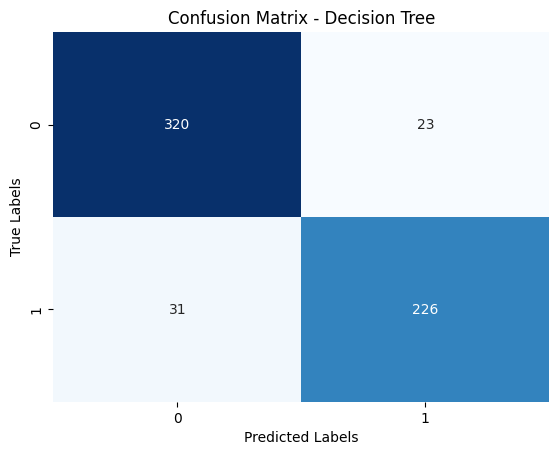

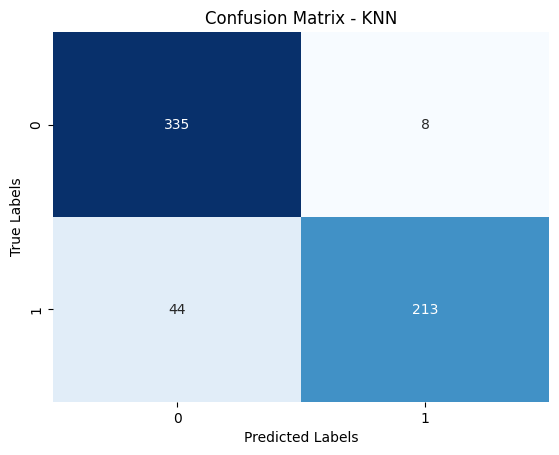

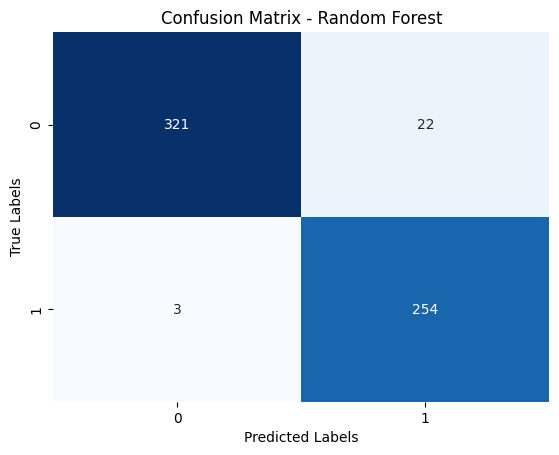

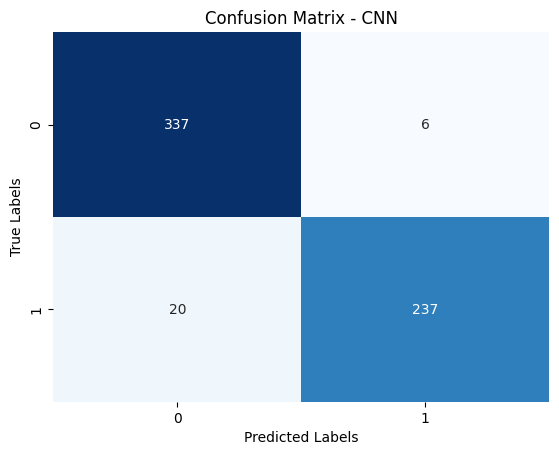

In [68]:
for name, model in models.items():
    accuracy, conf_matrix, class_report, y_proba = evaluate_non_cnn_model(model, x_test_scaled, y_test)
    accuracies.append(accuracy)
    conf_matrices.append(conf_matrix)
    class_reports.append(class_report)
    probas[name]= y_proba

    # Plot confusion matrix for each non-CNN model
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Plot training history for non-CNN models
    history = model.fit(x_train_scaled, y_train)
    histories[name] = history


plt.figure()
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - CNN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

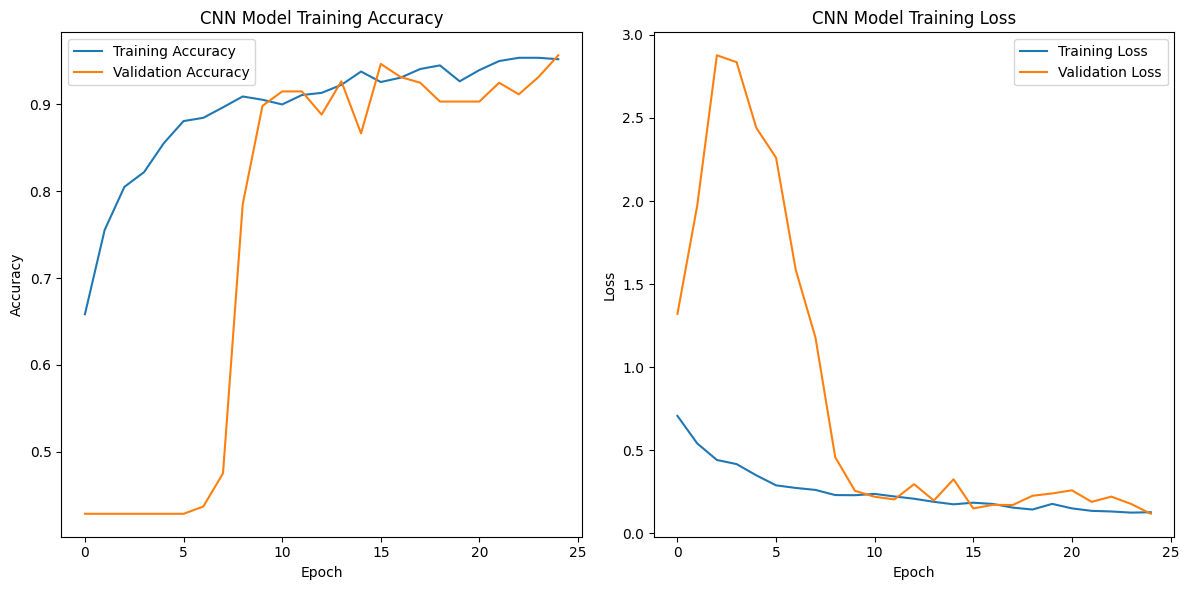

In [70]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [72]:
for i, name in enumerate(model_names):
    print(f"{name} Metrics:")
    print(f"Accuracy: {accuracies[i]:.2f}")
    print("Classification Report:")
    print(class_reports[i])
    print()


print("CNN Model Metrics:")
print(f"Accuracy: {accuracy_cnn:.2f}")
print("Classification Report:")
print(class_report_cnn)

Decision Tree Metrics:
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       343
           1       0.91      0.88      0.89       257

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600


KNN Metrics:
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       343
           1       0.96      0.83      0.89       257

    accuracy                           0.91       600
   macro avg       0.92      0.90      0.91       600
weighted avg       0.92      0.91      0.91       600


Random Forest Metrics:
Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       343
           1       0.92      0.99      0.95       257

    acc

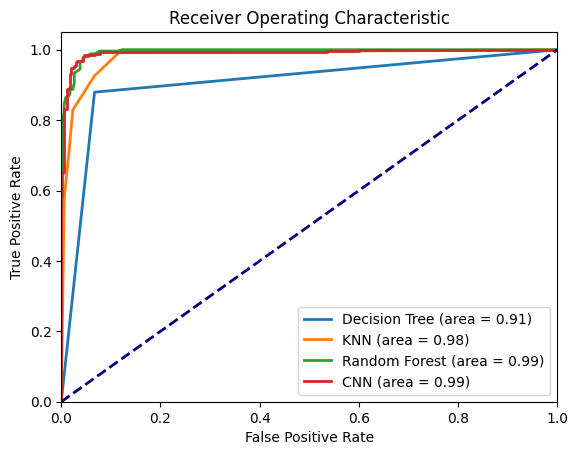

In [74]:
plt.figure()
for name, y_proba in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')

# Add CNN ROC curve
fpr_cnn, tpr_cnn, _ = roc_curve(np.argmax(y_test_cnn, axis=1), y_pred_prob_cnn[:, 1])
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.plot(fpr_cnn, tpr_cnn, lw=2, label=f'CNN (area = {roc_auc_cnn:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

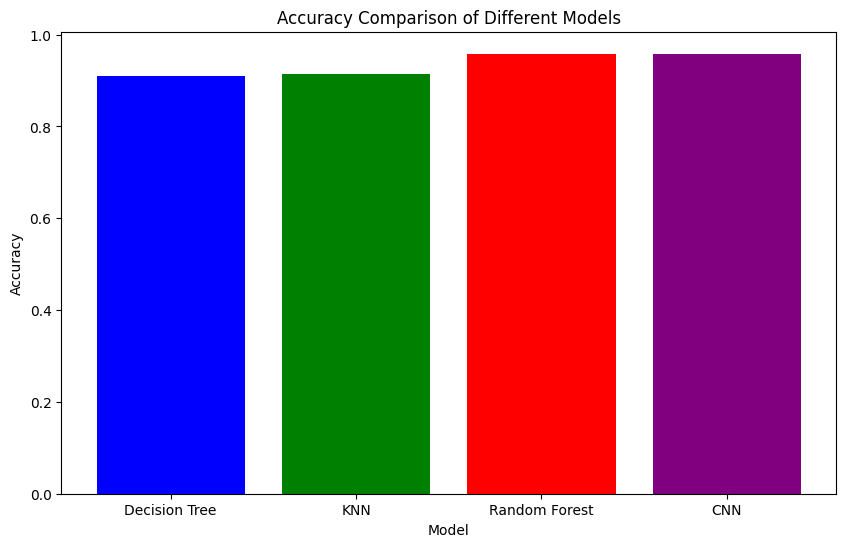

In [76]:
accuracies.append(accuracy_cnn)
model_names.append('CNN')
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.show()

In [80]:
pred_directory = 'pred'
new_size = (64, 64)

In [82]:
cnn_model = load_model('BrainTumor_Complex_CNN.h5')

In [84]:
def preprocess_image(image_path, size):
    image = cv2.imread(image_path)
    if image is not None:
        image = Image.fromarray(image, 'RGB')
        image = image.resize(size)
        return np.array(image)
    return None

In [94]:
# List image files in the pred directory
pred_images = glob.glob(os.path.join(pred_directory, '*'))
pred_images_data = []
pred_images_names = []

In [96]:
for image_path in pred_images:
    image_name = os.path.basename(image_path)
    image_data = preprocess_image(image_path, new_size)
    if image_data is not None:
        pred_images_data.append(image_data)
        pred_images_names.append(image_name)

pred_images_data = np.array(pred_images_data)


In [98]:
pred_images_cnn = normalize(pred_images_data.astype('float32'), axis=1)

In [100]:
cnn_predictions_prob = cnn_model.predict(pred_images_cnn)
cnn_predictions = np.argmax(cnn_predictions_prob, axis=1)
cnn_predictions_conf = np.max(cnn_predictions_prob, axis=1) 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


In [122]:
def display_results(images, predictions, probabilities, names):
    num_images = 25
    max_images_per_row = 5  # Adjust this value as needed

    # Ensure the number of subplots does not exceed the maximum
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row
    
    plt.figure(figsize=(15, 3 * num_rows))
    
    for i in range(num_images):
        plt.subplot(num_rows, max_images_per_row, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f'Image: {names[i]}\nPred: {"Tumor" if predictions[i] == 1 else "No Tumor"}\nConf: {probabilities[i]:.2f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


CNN Model Predictions:


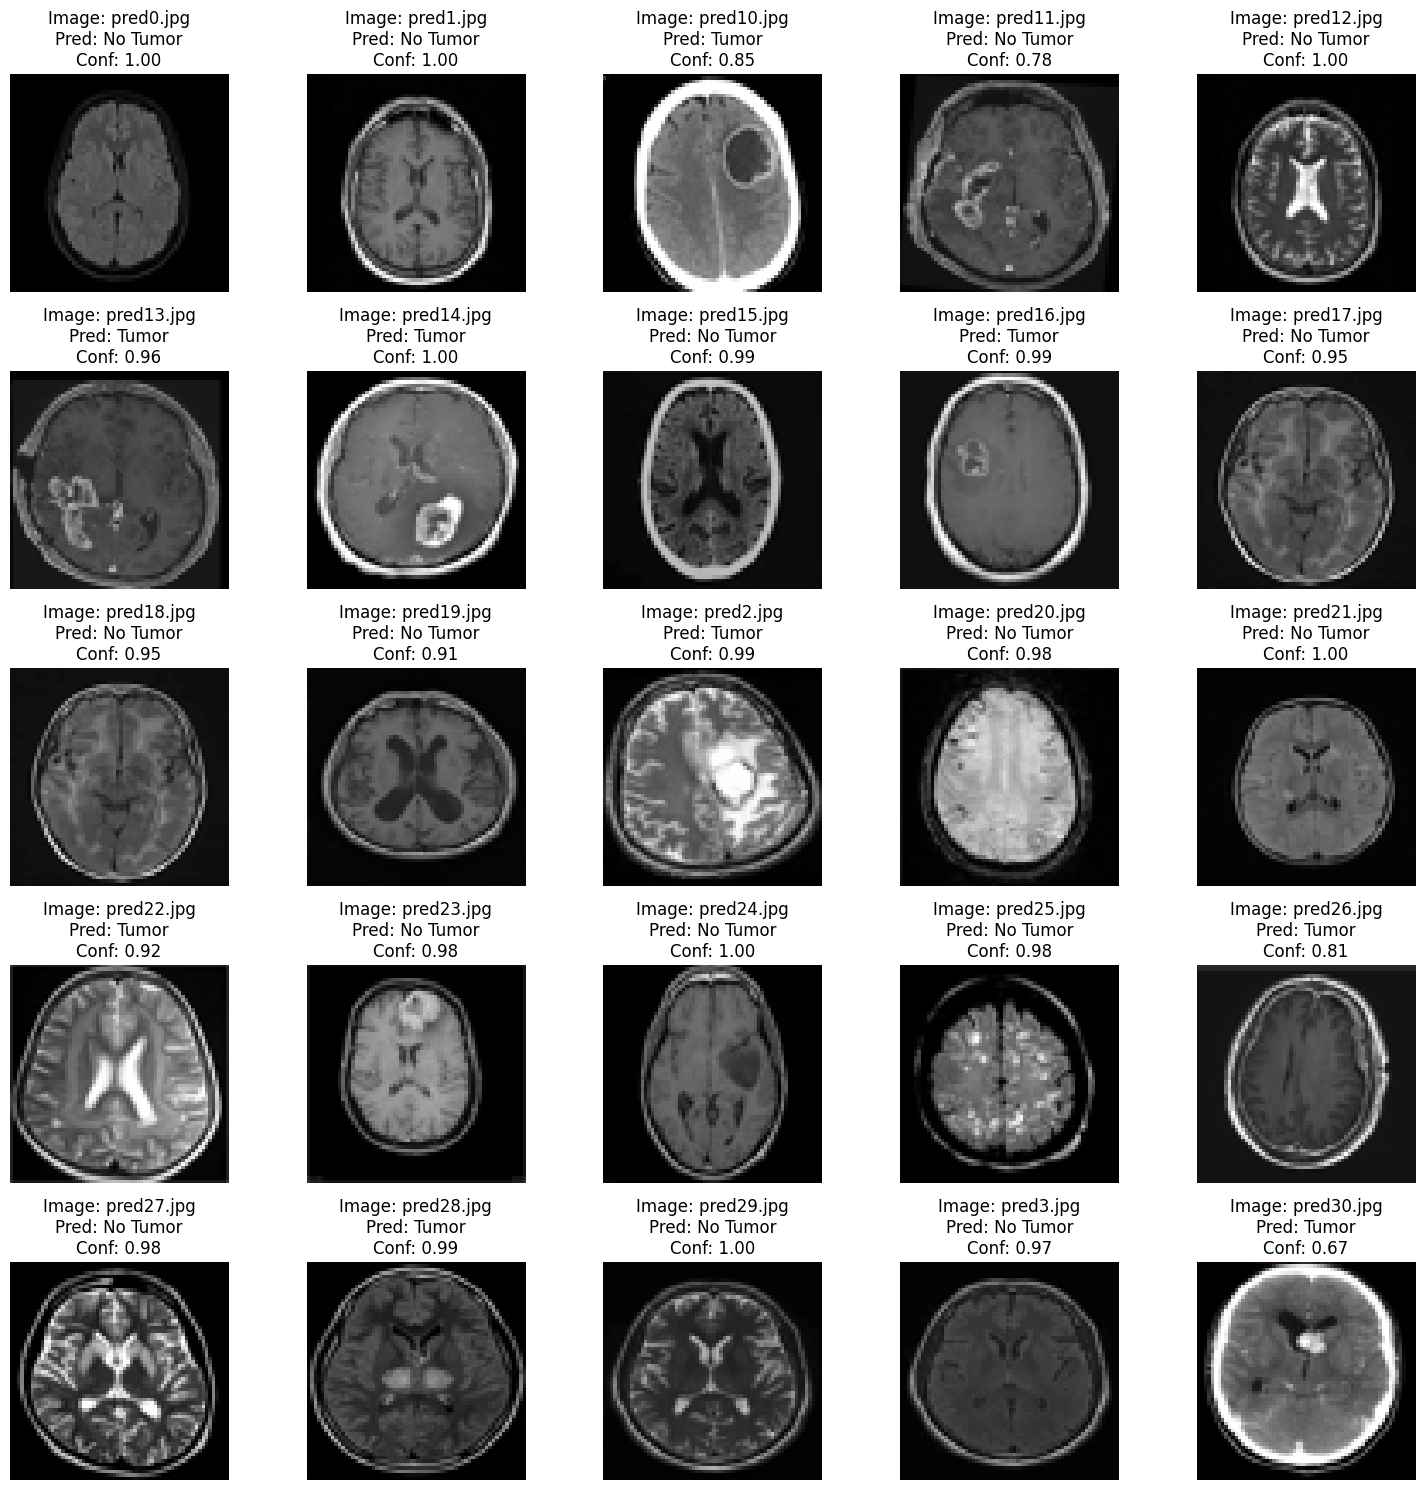

In [124]:
print('\nCNN Model Predictions:')
display_results(pred_images_data, cnn_predictions, cnn_predictions_conf, pred_images_names)

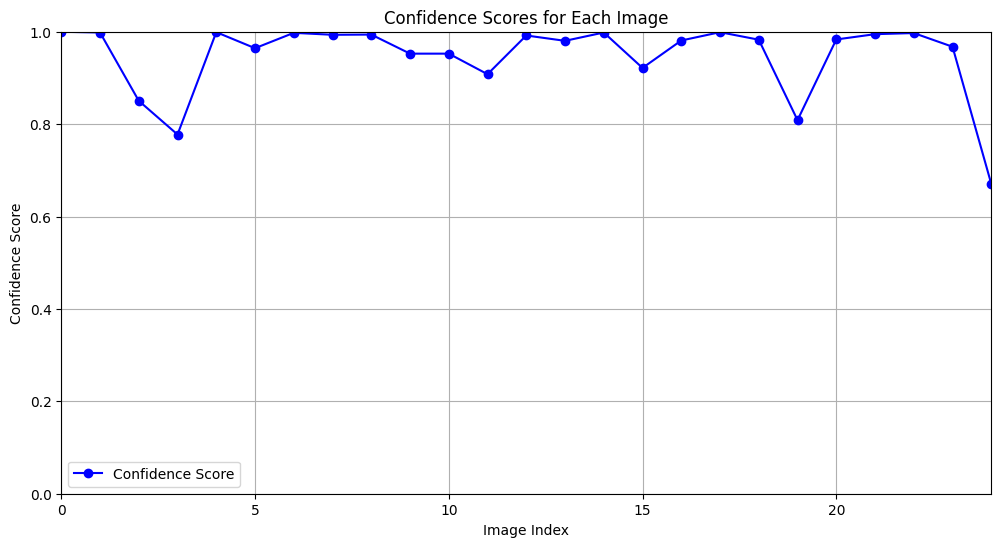

In [132]:
plt.figure(figsize=(12, 6))
plt.plot(cnn_predictions_conf, marker='o', linestyle='-', color='blue', label='Confidence Score')
plt.xlabel('Image Index')
plt.ylabel('Confidence Score')
plt.title('Confidence Scores for Each Image')
plt.ylim(0, 1)
plt.xlim(0,24)
plt.grid(True)
plt.legend()
plt.show()